# Импортируем библиотеки.

In [509]:
import pandas as pd, seaborn as sns, xgboost as xgb

from scipy.stats import trim_mean, median_abs_deviation
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_squared_error, mean_absolute_error

sns.set_theme(context = 'paper', style = 'whitegrid', 
              palette = 'dark', font_scale = 2, rc = {'figure.figsize': (20, 5)})

# Загружаем данные.

In [510]:
df_data = pd.read_csv('ВС DS Сбер data.csv', delimiter = ';')
df_usd = pd.read_csv('USD.csv')
df_euro = pd.read_csv('Euro.csv')
df_sp500 = pd.read_csv('sp500.csv', usecols = ['Date', 'Close/Last'])
df_kr = pd.read_csv('Key rate and inflation.csv', usecols = ['дата', 'Ключевая ставка. % годовых'])

# Правим данные.
## df_data.

In [511]:
df_data.columns = ['Report date', 'Value']
df_data['Report date'] = pd.to_datetime(df_data['Report date'], infer_datetime_format = True)
df_data.set_index('Report date', inplace = True)

df_data.shape

(2111, 1)

## df_usd.

In [512]:
df_usd.columns = ['Report date', 'USD']
df_usd['Report date'] = pd.to_datetime(df_usd['Report date'], infer_datetime_format = True)
df_usd['USD'].astype(float)

df_usd_train = df_usd[(df_usd['Report date'] >= pd.to_datetime('2013-12-30')) &
                    (df_usd['Report date'] <= pd.to_datetime('2019-10-10'))]

df_usd_train.set_index('Report date', inplace = True)

df_usd_train.shape

(1426, 1)

## df_euro.

In [513]:
df_euro.columns = ['Report date', 'Euro']
df_euro['Report date'] = pd.to_datetime(df_euro['Report date'], infer_datetime_format = True)
df_euro['Euro'].astype(float)

df_euro_train = df_euro[(df_euro['Report date'] >= pd.to_datetime('2013-12-30')) &
                    (df_euro['Report date'] <= pd.to_datetime('2019-10-10'))]

df_euro_train.set_index('Report date', inplace = True)

df_euro_train.shape

(1426, 1)

## df_sp500.

In [514]:
df_sp500.columns = ['Report date', 'S&P 500']
df_sp500['Report date'] = pd.to_datetime(df_sp500['Report date'], infer_datetime_format = True)
df_sp500['S&P 500'].astype(float)

df_sp500_train = df_sp500[(df_sp500['Report date'] >= pd.to_datetime('2013-12-30')) &
                    (df_sp500['Report date'] <= pd.to_datetime('2019-10-10'))]

df_sp500_train.set_index('Report date', inplace = True)

df_sp500_train.shape

(1474, 1)

## df_kr.

In [515]:
df_kr.columns = ['Key rate', 'Report date']
df_kr['Report date'] = pd.to_datetime(df_kr['Report date'], dayfirst = True)
df_kr['Key rate'].astype(float)

df_kr_train = df_kr[(df_kr['Report date'] >= pd.to_datetime('2013-12-01')) &
                    (df_kr['Report date'] <= pd.to_datetime('2019-10-01'))]

df_kr_train.set_index('Report date', inplace = True)

df_kr_train.shape

(71, 1)

## Связываем все данные в один датафрейм.

In [516]:
df_features_train = df_usd_train.join([df_euro_train, df_sp500_train, df_kr_train], how = 'outer')

df_features_train.shape

(1785, 4)

In [517]:
df_train = df_data.join(df_features_train)

print(df_train.shape)
df_train.head()

(2111, 5)


,Value,USD,Euro,S&P 500,Key rate
Report date,,,,,
2013-12-30,3457625638,NaN,NaN,1841.07,NaN
2013-12-31,3417092149,32.7292,44.9699,1848.36,NaN
2014-01-01,3417092149,32.6587,45.0559,1848.36,5.5
2014-01-02,3417092149,NaN,NaN,1831.98,NaN
2014-01-03,3417092149,NaN,NaN,1831.37,NaN


## Визуализируем объём средств.

<AxesSubplot: xlabel='Report date', ylabel='Value'>

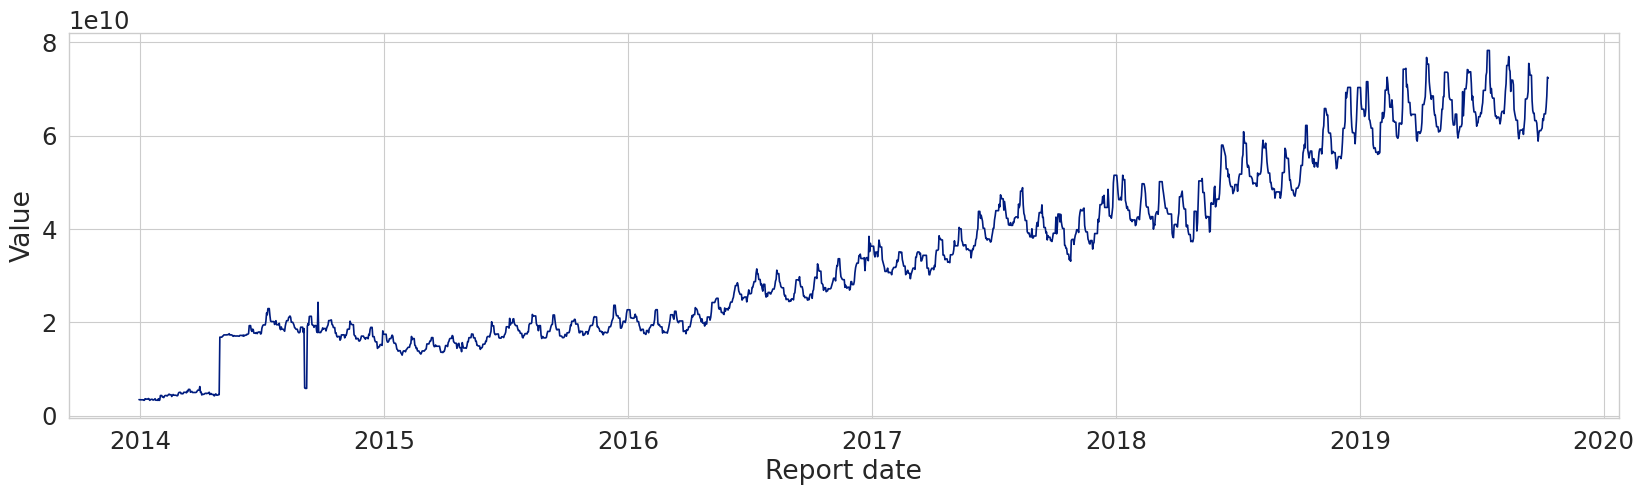

In [518]:
sns.lineplot(data = df_train['Value'])

# Исследовательский анализ данных.

## Мера центральной тенденции.

In [519]:
trimmed_mean = trim_mean(a = df_train['Value'], proportiontocut = .1)
print(f"Trimmed mean = {trimmed_mean}\nMean = {df_train['Value'].mean()}\nMedian = {df_train['Value'].median()}")

Trimmed mean = 32751604974.354057
Mean = 33896676186.65798
Median = 30213521890.0


## Дисперсия данных.

In [520]:
MAD = median_abs_deviation(x = df_train['Value'])
print(f"MAD = {MAD}\nVariance = {df_train['Value'].var()}\nStandard deviation = {df_train['Value'].std()}")

MAD = 12872115091.0
Variance = 3.517402079323293e+20
Standard deviation = 18754738279.494312


## Распределение данных.

<AxesSubplot: xlabel='Value'>

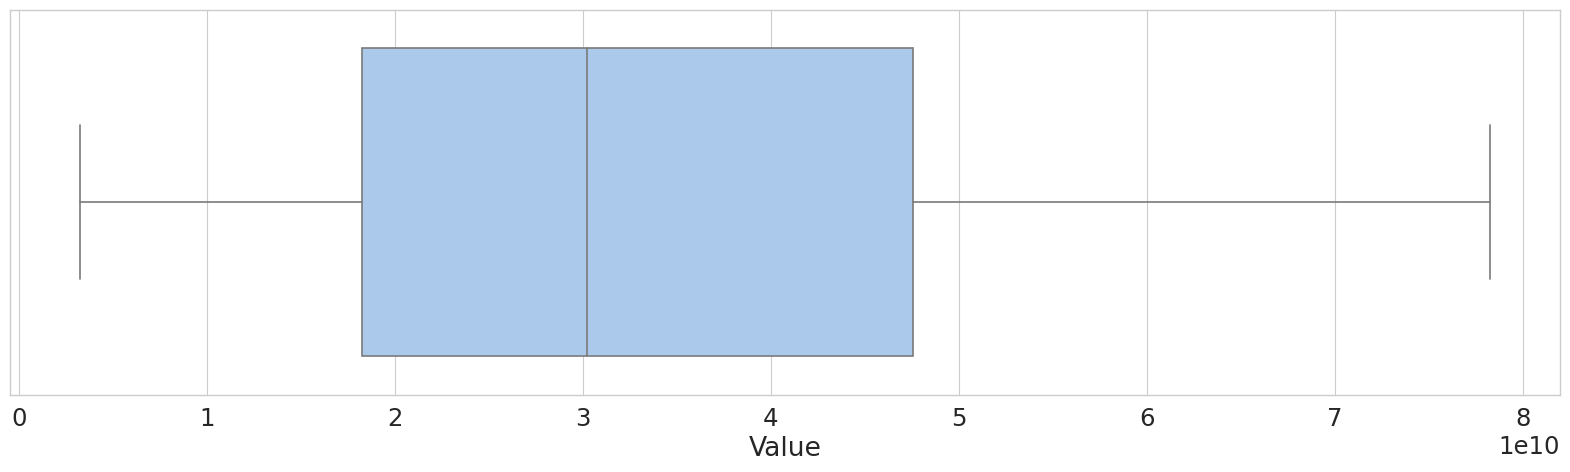

In [521]:
sns.boxplot(x = df_train['Value'], palette = 'pastel')

In [522]:
frequency_table = pd.cut(x = df_train['Value'], bins = 10).value_counts(sort = False)
print(frequency_table)

(3207863973.308, 10777388631.2]    125
(10777388631.2, 18271967500.4]     406
(18271967500.4, 25766546369.6]     395
(25766546369.6, 33261125238.8]     212
(33261125238.8, 40755704108.0]     239
(40755704108.0, 48250282977.2]     226
(48250282977.2, 55744861846.4]     139
(55744861846.4, 63239440715.6]     154
(63239440715.6, 70734019584.8]     159
(70734019584.8, 78228598454.0]      56
Name: Value, dtype: int64


<AxesSubplot: xlabel='Value', ylabel='Count'>

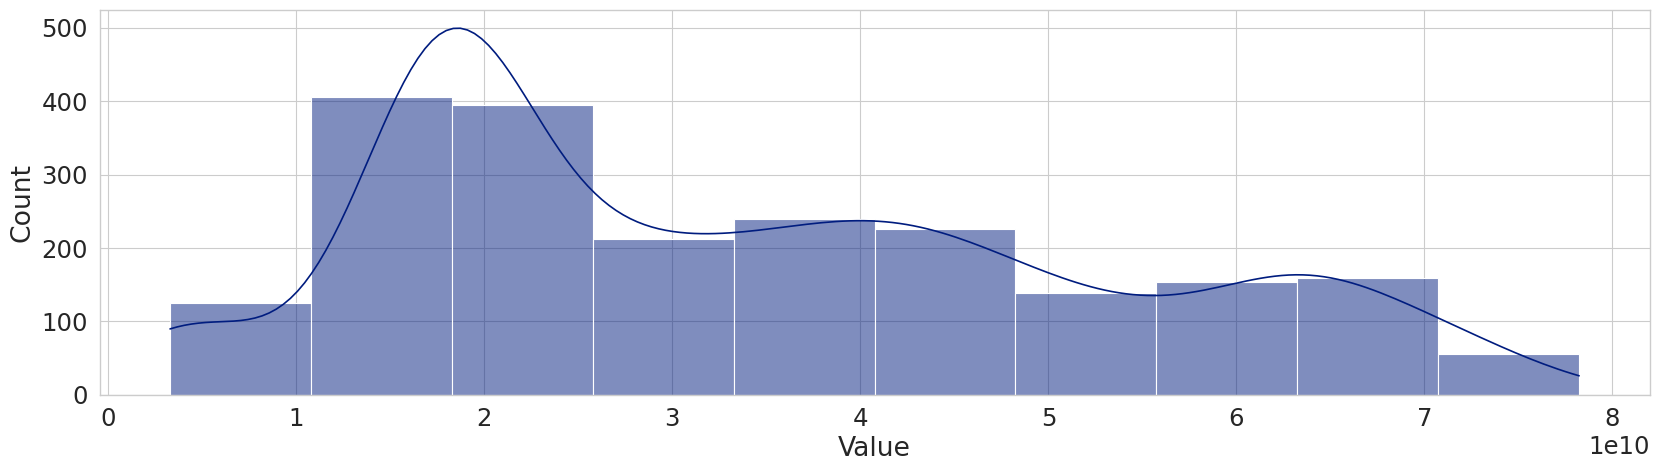

In [523]:
sns.histplot(x = df_train['Value'], bins = 10, kde = True)

# Корреляция.

<AxesSubplot: >

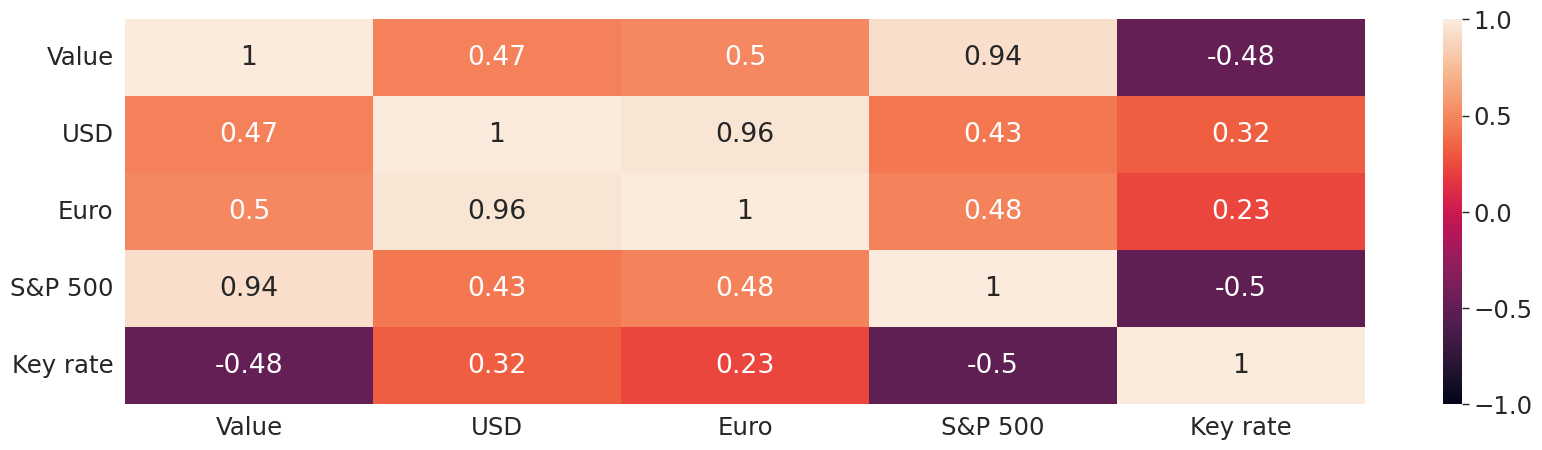

In [524]:
sns.heatmap(df_train.corr(), vmin = -1, vmax = 1, annot = True)

<AxesSubplot: xlabel='Value', ylabel='S&P 500'>

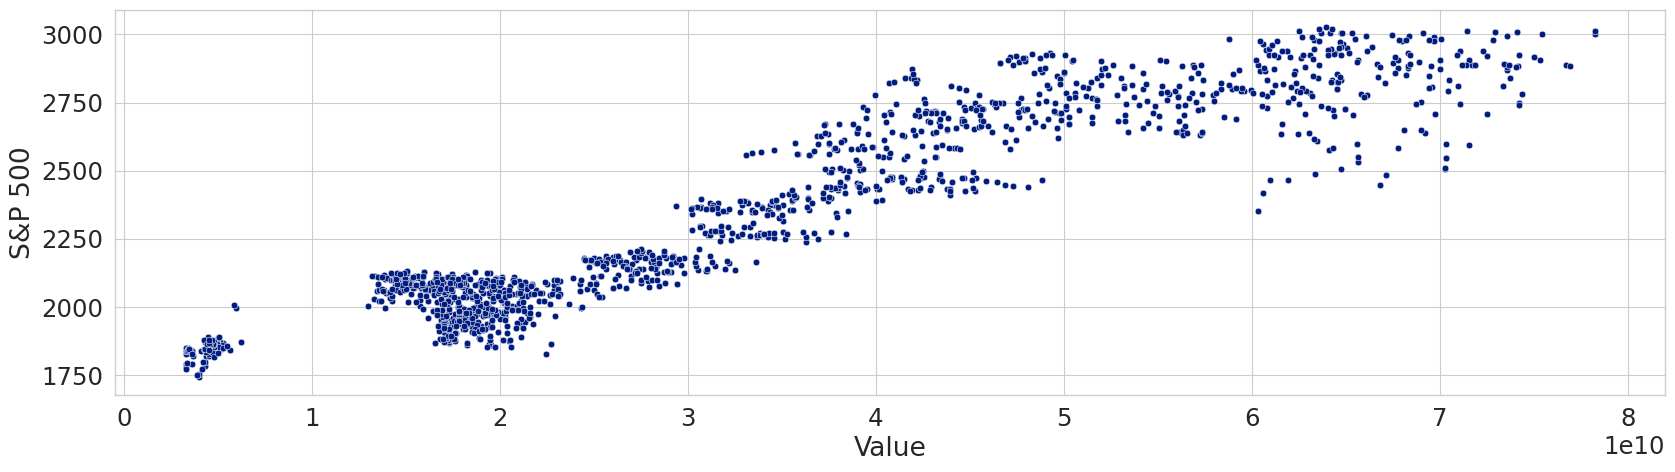

In [525]:
sns.scatterplot(x = df_train['Value'], y = df_train['S&P 500'])

# Заполняем пустые значения.

In [526]:
print(df_train['USD'].groupby(by = [df_train.index.year, df_train.index.month]).mean())
df_train['USD'] = df_train['USD'].groupby(by = [df_train.index.year, df_train.index.month],
                                          group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_train['Euro'] = df_train['Euro'].groupby(by = [df_train.index.year, df_train.index.month],
                                            group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_train['S&P 500'] = df_train['S&P 500'].groupby(by = [df_train.index.year, df_train.index.month],
                                                  group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_train['Key rate'].fillna(method = 'pad', inplace = True)
df_train['Key rate'].fillna(method = 'backfill', inplace = True)

Report date  Report date
2013         12             32.729200
2014         1              33.784353
             2              35.244040
             3              36.198565
             4              35.667727
                              ...    
2019         6              64.169050
             7              63.222682
             8              65.587483
             9              64.958705
             10             65.012438
Name: USD, Length: 71, dtype: float64


# Разбиваем данные на тренировочную и тестируемую выборку.

In [527]:
x = df_train.drop(['Value'], axis = 1)
y = df_train['Value']

In [528]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1 / 3, random_state = 20, shuffle = True)

# Создаём и обучаем модель.

In [529]:
xgbr = xgb.XGBRegressor()

In [530]:
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [531]:
r2 = r2_score(y_test, xgbr.predict(x_test))
MedianAE = median_absolute_error(y_test, xgbr.predict(x_test))
MeanSE = mean_squared_error(y_test, xgbr.predict(x_test))
MeanAE = mean_absolute_error(y_test, xgbr.predict(x_test))

print(r2)

0.9707114576017194


# Попробуем оценить объём стабильной части средств на каждое 20 число в течении 12 месяцев, начиная с 19.01.2020.

In [532]:
df_test = pd.DataFrame(index = pd.date_range(start = '02-20-2020', end = '03-20-2021', freq = 'D'))

In [533]:
df_sp500_test = df_sp500[(df_sp500['Report date'] >= pd.to_datetime('2020-02-20')) &
                    (df_sp500['Report date'] <= pd.to_datetime('2021-03-20'))]

df_sp500_test.set_index('Report date', inplace = True)

df_sp500_test.shape

(273, 1)

In [534]:
df_usd_test = df_usd[(df_usd['Report date'] >= pd.to_datetime('2020-02-20')) &
                    (df_usd['Report date'] <= pd.to_datetime('2021-03-20'))]

df_usd_test.set_index('Report date', inplace = True)

df_usd_test.shape

(244, 1)

In [535]:
df_euro_test = df_euro[(df_euro['Report date'] >= pd.to_datetime('2020-02-20'))&
                    (df_euro['Report date'] <= pd.to_datetime('2021-03-20'))]

df_euro_test.set_index('Report date', inplace = True)

df_euro_test.shape

(244, 1)

In [544]:
df_kr_test = df_kr[(df_kr['Report date'] >= pd.to_datetime('2020-02-01')) &
                   (df_kr['Report date'] <= pd.to_datetime('2021-02-01'))]

df_kr_test.set_index('Report date', inplace = True)

df_kr_test.shape

(13, 1)

In [551]:
df_test = df_usd_test.join([df_euro_test, df_sp500_test, df_kr_test], how = 'outer')

df_test.shape

(329, 4)

In [553]:
df_test['USD'] = df_test['USD'].groupby(by = [df_test.index.year, df_test.index.month],
                                        group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_test['Euro'] = df_test['Euro'].groupby(by = [df_test.index.year, df_test.index.month],
                                          group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_test['S&P 500'] = df_test['S&P 500'].groupby(by = [df_test.index.year, df_test.index.month],
                                                group_keys = False).apply(lambda x: x.fillna(value = x.mean()))

df_test['Key rate'].fillna(method = 'pad', inplace = True)
df_test['Key rate'].fillna(method = 'backfill', inplace = True)

In [555]:
x_test = df_test[df_test.index.day == 20]

<AxesSubplot: xlabel='Report date', ylabel='USD'>

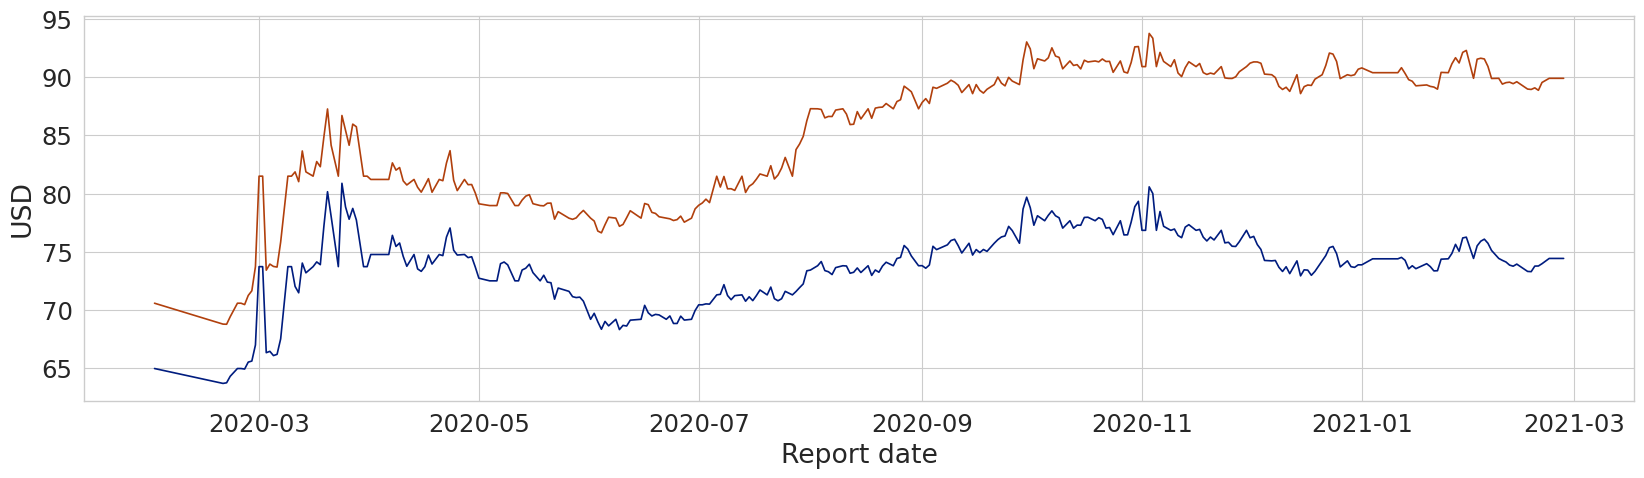

In [556]:
sns.lineplot(x = df_test.index, y = df_test['USD'])
sns.lineplot(x = df_test.index, y = df_test['Euro'])

<AxesSubplot: xlabel='Report date'>

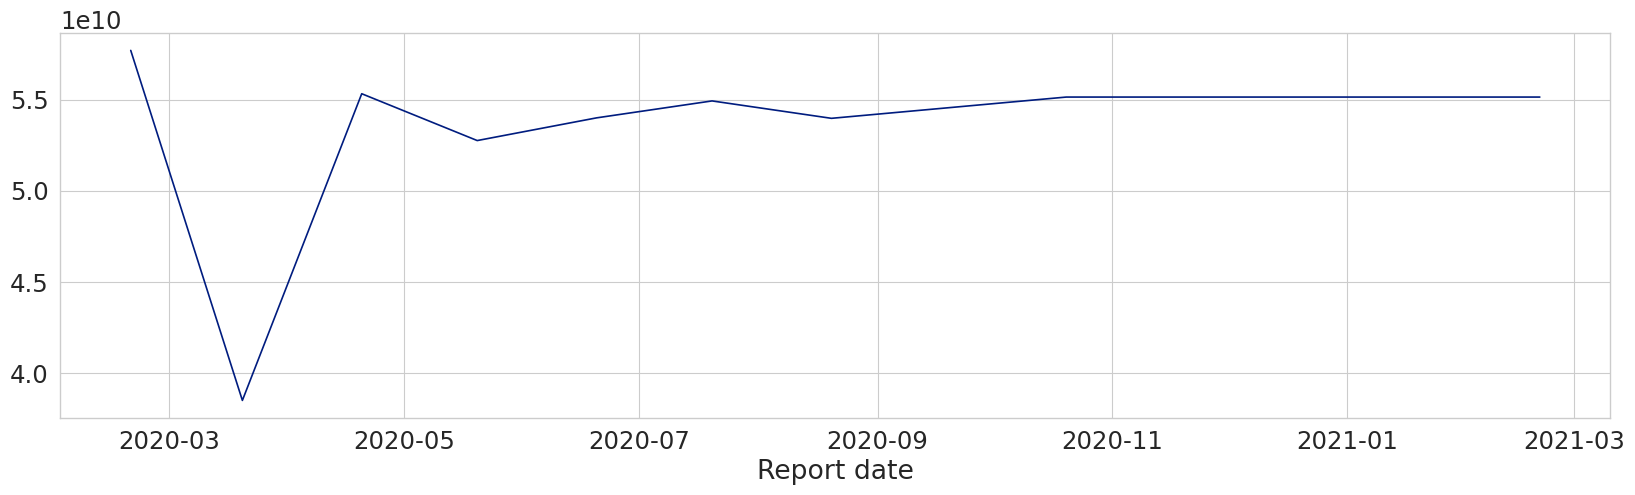

In [557]:
sns.lineplot(x = df_test.index[df_test.index.day == 20], y = xgbr.predict(x_test))